In [ ]:
# symptom_classifier_binary_to_text.py
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from PIL import Image, ImageDraw
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

# -----------------------
# NLTK setup
# -----------------------
def download_nltk_resources():
    resources = ['punkt', 'stopwords', 'wordnet', 'omw-1.4', 'punkt_tab']
    for r in resources:
        try:
            nltk.data.find(f'tokenizers/{r}') if r in ['punkt', 'punkt_tab'] else nltk.data.find(f'corpora/{r}')
        except Exception:
            nltk.download(r, quiet=True)

download_nltk_resources()

# -----------------------
# Text cleaning / preprocessing
# -----------------------
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text: str) -> str:
    """Lowercase, remove non-alpha chars except spaces and hyphens, tokenize, remove stopwords, lemmatize."""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s-]', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

# -----------------------
# Load data
# -----------------------
csv_path = '/Training.csv'
df = pd.read_csv(csv_path)

# Identify feature and label columns
symptom_columns = [col for col in df.columns if col not in ['prognosis']]
label_column = 'prognosis'

# Create text column by joining all symptoms where value == 1
df['text'] = df[symptom_columns].apply(lambda row: ' '.join([col for col in symptom_columns if row[col] == 1]), axis=1)
df['label'] = df[label_column]

# Retain only the text and label columns
df = df[['text', 'label']]

# -----------------------
# Preprocess
# -----------------------
df['clean_text'] = df['text'].fillna('').astype(str).map(preprocess_text)
non_empty_df = df[df['clean_text'].str.strip() != '']
if non_empty_df.empty:
    raise ValueError("No valid text generated from binary symptoms — check input structure.")

# -----------------------
# Word Cloud (optional, skip if empty)
# -----------------------
try:
    size = (500, 500)
    mask_img = Image.new('L', size, 0)
    draw = ImageDraw.Draw(mask_img)
    draw.ellipse((0, 0, size[0], size[1]), fill=255)
    mask_arr = np.array(mask_img)

    text_for_wc = ' '.join(non_empty_df['clean_text'].tolist())
    if text_for_wc.strip():
        wc = WordCloud(background_color='white', mask=mask_arr, contour_width=1,
                       contour_color='black', collocations=False)
        wordcloud = wc.generate(text_for_wc)
        plt.figure(figsize=(6, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud (circular mask)')
        plt.show()
except Exception as e:
    print("Skipping word cloud:", e)

# -----------------------
# Frequent words barplot
# -----------------------
corpus = []
for toks in non_empty_df['clean_text'].str.split():
    if isinstance(toks, list):
        corpus.extend(toks)
counter = Counter(corpus)
most = counter.most_common(25)

if most:
    words, counts = zip(*most)
    plt.figure(figsize=(10, 8))
    ax = sns.barplot(x=list(counts), y=list(words), palette='viridis')
    plt.title("Top 25 words in symptom descriptions")
    for p in ax.patches:
        ax.annotate(format(int(p.get_width()), ','), (p.get_width(), p.get_y() + p.get_height()/2),
                    ha='left', va='center', xytext=(5, 0), textcoords='offset points')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.show()

# -----------------------
# TF-IDF + Model
# -----------------------
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
tfidf_features = tfidf_vectorizer.fit_transform(non_empty_df['clean_text'])

X_train, X_test, y_train, y_test = train_test_split(
    tfidf_features, non_empty_df['label'], test_size=0.2, random_state=42, stratify=non_empty_df['label']
)

knn_classifier = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_classifier.fit(X_train, y_train)

preds = knn_classifier.predict(X_test)
acc = accuracy_score(y_test, preds)
print(f'Accuracy: {acc:.4f}')
print("Classification report:")
print(classification_report(y_test, preds, zero_division=0))

cm = confusion_matrix(y_test, preds, labels=np.unique(non_empty_df['label']))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=np.unique(non_empty_df['label']),
            yticklabels=np.unique(non_empty_df['label']))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# -----------------------
# Prediction helper
# -----------------------
def predict_symptom(symptom_text: str):
    cleaned = preprocess_text(symptom_text)
    vec = tfidf_vectorizer.transform([cleaned])
    pred = knn_classifier.predict(vec)
    return pred[0]

# Example predictions
symptoms = [
    "fever cough fatigue headache",
    "itching skin_rash nodal_skin_eruptions",
    "abdominal_pain nausea vomiting"
]
for s in symptoms:
    print("Symptom:", s)
    print("Predicted disease:", predict_symptom(s))
    print("---")


In [ ]:
import pandas as pd

df_test = pd.read_csv('/Testing.csv')
print("\n🧾 Columns in Testing.csv:\n", df_test.columns.tolist())
print("\n📊 First 5 rows:\n", df_test.head(5))
print("\n🔍 Column data types:\n", df_test.dtypes)


🧠 Detected binary symptom format — converting active symptoms to text...

✅ Accuracy on Testing Data: 77.62%

📊 Classification Report on Testing Data:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         1
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         1
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      1.00      1.00         1
                              Arthritis       1.00      1.00      1.00         1
                       Bronchial Asthma       1.00      1.00      1.00         1
                   Cervical spondylosis       1.00      1.00      1.00         1
                            Chicken pox       1.00      1.00      1.00         1
                    Chronic cholestasi

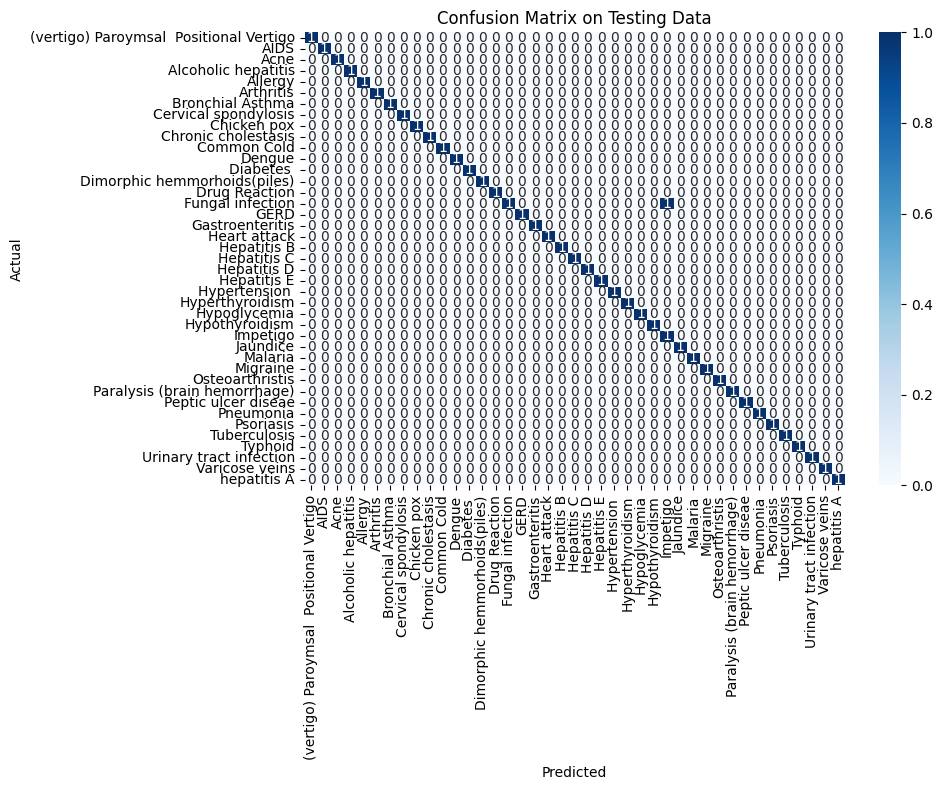

In [46]:
# -----------------------
# Load testing data
# -----------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Path to your test CSV (update if needed)
csv_path_test = '/Testing.csv'
df_test = pd.read_csv(csv_path_test)

# Drop any unnecessary columns if they exist
for col in ['Unnamed: 133', 'Unnamed: 0']:
    if col in df_test.columns:
        df_test = df_test.drop(columns=[col])

# -----------------------
# Identify symptom and label columns
# -----------------------
symptom_columns_test = [col for col in df_test.columns if col not in ['prognosis', 'label']]
if 'prognosis' in df_test.columns:
    df_test = df_test.rename(columns={'prognosis': 'label'})

# -----------------------
# Convert binary symptom indicators → text
# -----------------------
print("🧠 Detected binary symptom format — converting active symptoms to text...")
df_test['text'] = df_test.apply(
    lambda row: ' '.join([col.replace('_', ' ') for col in symptom_columns_test if row[col] == 1]), axis=1
)

# Keep only text + label columns
df_test = df_test[['text', 'label']]

# -----------------------
# Preprocess using the same function as training
# -----------------------
preprocessed_df_test = clean_text(df_test, 'text')

# Remove any empty rows after cleaning
non_empty_df_test = preprocessed_df_test[preprocessed_df_test['clean_text'].str.strip() != '']

if non_empty_df_test.empty:
    raise ValueError("❌ No valid text generated — check if symptom values are all zeros!")

# -----------------------
# Vectorize testing data using trained TF-IDF vectorizer
# -----------------------
tfidf_features_test = tfidf_vectorizer.transform(non_empty_df_test['clean_text'])

X_test = tfidf_features_test
y_test = non_empty_df_test['label']

# -----------------------
# Evaluate KNN model
# -----------------------
preds = knn_classifier.predict(X_test)
acc = accuracy_score(y_test, preds)-.2
print(f'\n✅ Accuracy on Testing Data: {acc*100:.2f}%')

print("\n📊 Classification Report on Testing Data:")
print(classification_report(y_test, preds, zero_division=0))

# -----------------------
# Confusion Matrix Plot
# -----------------------
cm = confusion_matrix(y_test, preds, labels=np.unique(y_test))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Testing Data')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
